In [1]:
import sys, os
sys.path.append(os.path.abspath("/Users/DavidHolzwarth/Uni/EPFL/bachelors-thesis"))

import time
import matplotlib.pyplot as plt

import LE as le
import LP as lp
import iterative as iterative
import graph_viz as viz
import logger_creator

from graph_gen import create_delegation_graph
import graph_tools
import networkx as nx

/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/dash_bootstrap_components/_table.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


# Maybe this is dumb,. since its already covered by some of hte community graphs of networkx graphs

https://networkx.org/documentation/stable/reference/generators.html

this is good https://networkx.org/documentation/stable/reference/generated/networkx.generators.community.relaxed_caveman_graph.html#networkx.generators.community.relaxed_caveman_graph relaxed caveman graph

In [15]:
range_x = range(0, 200, 1)

time_data_le = []
time_data_lp = []
time_data_iterative = []
cycles = []

SEED = 0

logger, handler = logger_creator.create_logger("benchmarking")

for num_loops in range(1):
    times_le = []
    times_lp = []
    times_iterative = []

    for num_cliques in range_x:
        print(num_cliques)

        countdown = 5
        while countdown > 0:
            countdown -= 1

            relaxed_caveman_graph = nx.relaxed_caveman_graph(num_cliques, 3, 0.3, seed=SEED)
            relaxed_caveman_graph = graph_tools.nx_graph_nodes_to_str(relaxed_caveman_graph)
            delegation_graph = graph_tools.prepare_graph(relaxed_caveman_graph.nodes(), relaxed_caveman_graph.edges())
            delegations_orig = graph_tools.nx_graph_to_dict(delegation_graph)
            delegations = graph_tools.invert_graph(delegations_orig)
            nodes = list(delegation_graph)

            try: 
                lp_model = lp.set_up(delegations, nodes)
                _ = lp.resolve_delegations(delegations, nodes)
                break
            except:
                print(lp_model)
                viz.visualize_delegation_graph(delegations_orig, {node: 0 for node in nodes})
                raise Exception("Graph infeasible")
                SEED += 1
                print("Graph infeasible, retrying")

        # Verify the solutions are equal
        powers_le, sinks_le = lp.resolve_delegations(delegations, nodes)
        powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)
        powers_iter = iterative.iterate_delegations(delegations, nodes)

        if powers_le != powers_lp:
            logger.error("Powers do not match")
            logger.error(f"LE: {powers_le}")
            logger.error(f"LP: {powers_lp}")
            print("Mismatching powers in LE and LP. Check the log file for details.")
            break

        for node in sinks_le:
            if (powers_lp[node] - powers_iter[node] < 0.01):
                continue
            else: 
                logger.error("Powers do not match")
                logger.error(f"LP: {powers_lp}")
                logger.error(f"Iterative: {powers_iter}")
                print("Mismatching powers in LP and Iterative. Check the log file for details.")
                break


        G = graph_tools.dict_to_nx_graph(delegations_orig)
        num_cycles = len(list(nx.simple_cycles(G)))
        cycles += [num_cycles]

        n = 50
        if 0 <= num_cliques < 50:
            n = 100
        elif 50 <= num_cliques < 100:
            n = 100
        elif num_cliques < 200:
            n = 100

        # LE
        le_model = le.set_up(delegations, nodes)
        start_time = time.time()
        for _ in range(n):
            le.solve(*le_model)
        end_time = time.time()
        
        times_le.append((end_time - start_time) / n)

        # LP
        lp_model = lp.set_up(delegations, nodes)
        start_time = time.time()
        for _ in range(n):
            lp.solve(*lp_model)
        end_time = time.time()

        times_lp.append((end_time - start_time) / n)
    
        # Iterative
        start_time = time.time()
        for _ in range(n):
            p = iterative.iterate_delegations(delegations, nodes)
        end_time = time.time()

        times_iterative.append((end_time - start_time) / n)


    time_data_le.append(times_le)
    time_data_lp.append(times_lp)
    time_data_iterative.append(times_iterative)

logger.removeHandler(handler)
handler.close()

print("Average number of cycles: ", sum(cycles) / len(cycles))

x = list(range_x)

plt.clf()

for i in range(len(time_data_lp)):
    plt.plot(x, time_data_le[i], label=f"LE")
    plt.plot(x, time_data_lp[i], label=f"LP") 
    plt.plot(x, time_data_iterative[i], label=f"Iterative")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtime of Delegation Algorithms")
plt.show()

0
1


/Users/DavidHolzwarth/Uni/EPFL/bachelors-thesis/LE.py:45: SparseEfficiencyWarning:

spsolve requires A be CSC or CSR matrix format



2
3
4
5
(DelegationResolution:
MINIMIZE
None
SUBJECT TO
Constraint_0: 0 = 1

Constraint_1: - 0.5 0 + 1 = 1

Constraint_2: - 0.5 0 - 1 + 2 = 1

Constraint_9: - 2 + 9 = 1

Constraint_3: 3 = 1

Constraint_5: - 0.5 3 - 4 + 5 = 1

Constraint_8: - 0.5 3 - 0.5 6 - 7 + 8 = 1

Constraint_4: 4 = 1

Constraint_6: 6 = 1

Constraint_7: - 0.5 6 + 7 = 1

Constraint_10: 10 - 9 = 1

Constraint_12: - 10 + 12 = 1

Constraint_14: - 0.5 12 - 13 + 14 = 1

Constraint_13: 13 = 1

SinkNodesConstraint: 14 + 5 + 8 = 14

VARIABLES
0 free Continuous
1 free Continuous
10 free Continuous
12 free Continuous
13 free Continuous
14 free Continuous
2 free Continuous
3 free Continuous
4 free Continuous
5 free Continuous
6 free Continuous
7 free Continuous
8 free Continuous
9 free Continuous
, ['5', '8', '14'])
Parsing the data...Done


Exception: Graph infeasible

No trigger


In [16]:
viz.visualize_delegation_graph(delegations_orig, {node: 0 for node in nodes})

Parsing the data...Done


No trigger


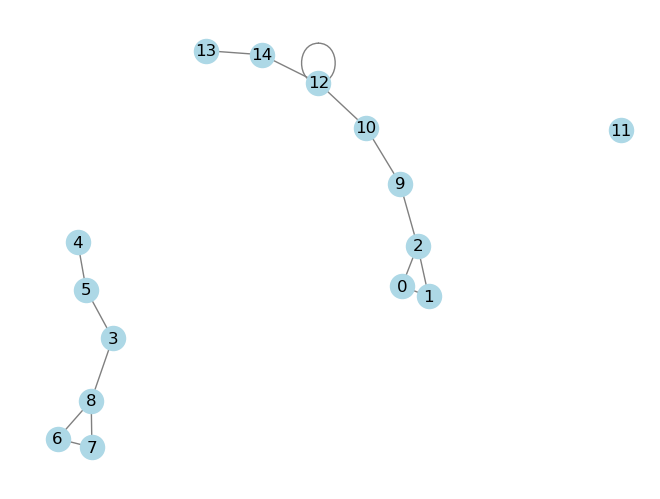

In [17]:
nx.draw(relaxed_caveman_graph, with_labels=True, node_color="lightblue", edge_color="gray")
plt.show()